# Natural Language Processing: Sentiment Analysis

**Author**: Albane Colmenares <br>
**Date**: December 12th, 2023 <br>
___________________________________________________________________________

### <u>Table of Content</u>
**1. Overview**<br>
**2. Business Understanding**<br>
**3. Data Understanding**<br>
**4. Data Preparation**<br>
**5. Modeling**<br>
**6. Evaluation**<br>
**7. Findings & Recommendations**<br>
**8. Limits & Next Steps**<br>

## 1. Overview

This notebook examines tweets about several brands and products and predicts whether the sentiment of the short text is positive, negative or neutral. <br>
The organization of this notebook follows the CRoss Industry Standard Process for Data Mining (CRISP-DM) is a process model that serves as the base for a data science process.

Text Text Text Text Text Text 

## 2. Business Understanding

Business and data understanding: *what kind of data are you using, and what makes it well-suited for the business problem?*
* You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 3. Data Understanding

**Data Source**

The data comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions). 


------------- REPHRASE THIS ------------- 

*Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.*

------------- REPHRASE THIS ------------- 

The file `judge-1377884607_tweet_product_company.csv` can be downloaded at the provided link. 
It was then renamed to `tweet_product_company.csv`and saved into the current folder, within the 'data' subfolder, to be accessed into the raw DataFrame. 


Text Text Text Text Text Text 

**Features**

Prior to preprocessing, the columns are: 

* `tweet_text`: the actual tweet's record
* `emotion_in_tweet_is_directed_at`: the product or company referred to in the tweet
* `is_there_an_emotion_directed_at_a_brand_or_product`: the tweet's sentiment

Text Text Text Text Text Text 

**Target**

The tweet's sentiment is the target for the dataset. The specific column is `is_there_an_emotion_directed_at_a_brand_or_product`. Based on a given set of tweets, we will try to predict if the tweet's emotion was positive, negative or neutral. 

**Loading the data**

In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import nltk

%matplotlib inline

The text file is encoded using Latin-1 encoding - and is open as is. Several encodings were tried to ensure the right one matched: utf-8, utf-16, ascii for example.

In [2]:
# Loading dataset and saving it as raw_df
raw_df = pd.read_csv('data/tweet_product_company.csv', encoding='latin-1')

In [3]:
# Inspecting the first 5 rows of the DataFrame
raw_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
print(f'The dataset has '+ str(len(raw_df)) + ' rows and 3 columns.' )

The dataset has 9093 rows and 3 columns.


The various companies and products referred to in the tweets will be reviewed to get an understand of the balance in the dataset, along with what is being most often reviewed.  

Similarly, the emotions will be reviewed in a similar way. 

In [5]:
# Inspecting the number of tweets referring to each product or company
raw_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
# Inspecting the number of tweets referring to each emotion
raw_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## 4. Data Preparation

This includes data cleaning and exploratory data analysis with `nltk`


more text <br>
more text <br>
more text <br>
more text <br>
more text <br>
more text <br>


*why did you choose the data preparation steps that you did, and what was the result?*

* This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
* Be sure to list the packages/libraries used to prepare the data, and why


For a better readability of the tweets' texts, the column width will be increased. In addition, the use of MathJax will be disabled so that the visual representation of mathematical expressions are not displayed so this doesn't cause issues to the environment. 

In [7]:
# Increasing column width
pd.set_option('max_colwidth', 400)
pd.set_option('use_mathjax', False)

### 4. a) Column names' change

The column names are particularly long. For an easier process to handle, they will be renamed in the new DataFrame called `df`:
* `tweet`
* `product_or_company`
* `sentiment`


In [8]:
# Making a copy of the raw DataFrame to modify it
df = raw_df.copy()

In [9]:
# Defining the new columns' names and attributing them to the new DataFrame
df.columns = ['tweet', 'product_or_company', 'sentiment']

In [10]:
# Verifying the changes applied  
df.head()

,tweet,product_or_company,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### 4. c) Missing data

In the next section, the missing values are inspected and handled by category. 
<br>
The `tweet` column only had 1 row with null values and had no implication on other features: it is removed. 
<br>
The `product_or_company` requires contains many more missing values. 

In [11]:
# Looking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  3291 non-null   object
 2   sentiment           9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* **Tweet**

The tweet column only has one null value with no information on the other columns: it will be dropped from the DataFrame.  

In [12]:
# Inspecting the tweet containing null information 
df[df['tweet'].isnull()]

,tweet,product_or_company,sentiment
6,NaN,NaN,No emotion toward brand or product


The null tweet does not contain any information for either column and will be dropped.  

In [13]:
# Dropping the null tweet from the DataFrame

df = df.dropna(subset=['tweet'])

In [14]:
# Verifying it was correctly removed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  3291 non-null   object
 2   sentiment           9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [15]:
print(f'The dataset now has '+ str(len(df)) + '. The missing tweet was removed.' )

The dataset now has 9092. The missing tweet was removed.


* **Product or Company**

The product_or_company column contains many null values where neither the product or the brand was specified. For now, all null values will be replaced by 'unknown', as the focus is to predict sentiment. 
<br>If the focus on product or company needs to be done, two columns will be created to identify the product and the brand. 

In [16]:
# Inspecting the tweet containing null information 
df[df['product_or_company'].isnull()]

,tweet,product_or_company,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [17]:
# Replacing the null product or company with 'undefined'
df['product_or_company'] = df['product_or_company'].fillna('undefined')

In [18]:
# Verifying it was correctly handled
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  9092 non-null   object
 2   sentiment           9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [19]:
print(f'The dataset still has '+ str(len(df)) + '.' )

The dataset still has 9092.


In [20]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts()

undefined                          5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product_or_company, dtype: int64

In [21]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts(normalize=True)

undefined                          0.638033
iPad                               0.104048
Apple                              0.072701
iPad or iPhone App                 0.051694
Google                             0.047294
iPhone                             0.032666
Other Google product or service    0.032226
Android App                        0.008909
Android                            0.008579
Other Apple product or service     0.003850
Name: product_or_company, dtype: float64

### 4. d) Handling duplicates

In [22]:
# How many rows were duplicates
print(str(len(df[df.duplicated()])) + f' duplicate rows were identified.')

22 duplicate rows were identified.


In [23]:
# Viewing the duplicate rows
df[df.duplicated()]

,tweet,product_or_company,sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",undefined,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,undefined,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,undefined,No emotion toward brand or product
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter",undefined,No emotion toward brand or product
5881,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",undefined,No emotion toward brand or product


In [24]:
# Verifying with one example that tweets were indeed duplicated 
df[df['tweet'] == 'Before It Even Begins, Apple Wins #SXSW {link}']

,tweet,product_or_company,sentiment
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion


In [25]:
# Dropping duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9070 non-null   object
 1   product_or_company  9070 non-null   object
 2   sentiment           9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


### 4. d) Turning sentiment classification into a binary one

* **Product or Company**

The product or company column does not have an impact on whether a tweet is positive or negative, so it will not be transformed as it will not be used further for predictions. 

* **Sentiment**

Four sentiment categories are described, which could be grouped in three: positive, negative, neutral. 
<br>This is what will be covered over the next section. 

In [26]:
# Number of rows by emotion
df['sentiment'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: sentiment, dtype: int64

* **Categorizing**

Due to the nature of the target, we will focus on the positive ones. Hence all the other tweets, whether they are neutral or negative, will be considered *not positive*, so will be identified as negative.

In [27]:
# Defining the new classifications for the sentiment column 
classification_columns = {
    'sentiment': {
        "No emotion toward brand or product": "negative", 
        "I can't tell": "negative", 
        "Positive emotion": "positive", 
        "Negative emotion": "negative" 
    }
}

In [28]:
# Converting the sentiment column classification

# Defining columns to change
column_classification = ['sentiment']

def convert_class(df, columns_mapping):
    for column, mapping in columns_mapping.items():
        print('Before: ' + column, df[column].unique())
        df[column] = df[column].map(mapping)
        print('After: ' + column, df[column].unique())
    

In [29]:
convert_class(df, classification_columns)

Before: sentiment ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
After: sentiment ['negative' 'positive']


In [30]:
# Number of rows by unique sentiment
df['sentiment'].value_counts()

negative    6100
positive    2970
Name: sentiment, dtype: int64

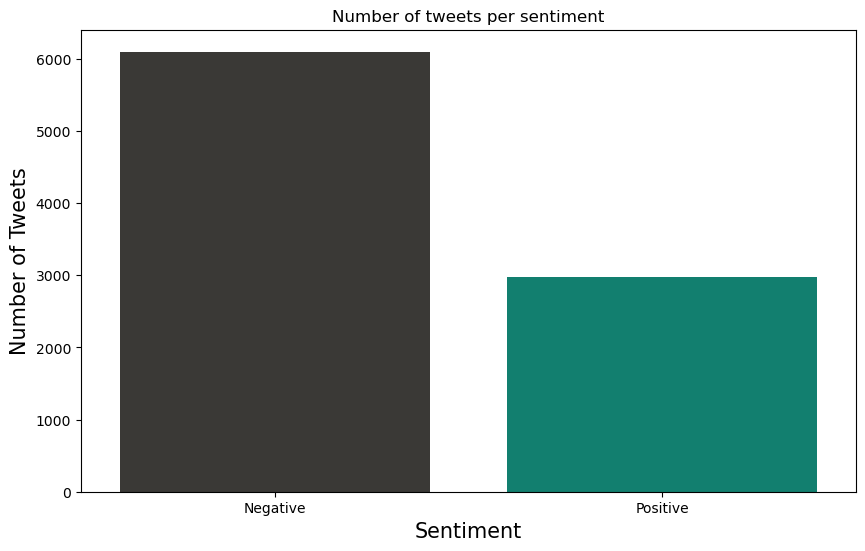

In [31]:
# Creating a bar chart for to visualize class imbalance
fig, ax = plt.subplots(figsize=(10,6))

# Defining custom colors 
custom_colors = ['#3B3935', '#00917C']

sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette=custom_colors)

ax.set_xlabel(xlabel = 'Sentiment', fontsize=15)
ax.set_ylabel(ylabel = 'Number of Tweets', fontsize=15)

ax.set_xticklabels(labels=['Negative', 'Positive'])

ax.set_title(f'Number of tweets per sentiment')

plt.show()

### 4. e) Performing a Train-Test Split

In [32]:
# Splitting df into X and y
X = df.drop('sentiment', axis=1)
y = df['sentiment']

In [33]:
X_train, X_test, y_train, _test = train_test_split(X, y, random_state=42, stratify=y)

In [34]:
X_train.head()

,tweet,product_or_company
8268,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,Google
945,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,undefined
8832,free #sxsw playlist.. enjoy {link},undefined
7771,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,Android App
1643,#justmet @mention who worked for Apple for 25 years! #SXSW,Apple


In [35]:
y_train.head()

8268    positive
945     negative
8832    negative
7771    positive
1643    positive
Name: sentiment, dtype: object

* **Distribution of Target**

In [36]:
train_target_counts = pd.DataFrame(y_train.value_counts())
train_target_counts.index.name = 'target name'
train_target_counts.rename(columns={'sentiment': 'count'}, inplace=True)

In [37]:
train_target_counts

,count
target name,
negative,4575
positive,2227


* **Visually Inspecting Features**

In [38]:
# Making a sample of 5 records to display the full text of each
train_sample = X_train.sample(5, random_state=22)
train_sample['label'] = [y_train[val] for val in train_sample.index]
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet,product_or_company,label
3586,Dang it. I've touched an iPad 2. I WANT! *sigh* #SXSW,iPad,positive
3901,Has made it into the press room got the swag and registered for an iPad 2. Hopefully get to meet mike tyson and @mention #sxsw,undefined,negative
133,"#Samsung, #Sony follow #Apple, #HP lead @mention {link} #Austin #atx #SXSW",undefined,negative
7937,UberGenius: Uber Is Taking Control of SXSW Pedicabs {link} #iPhone #LIVESTRONG #NewYorkCity #SanFrancisco #SXSW,undefined,negative
85,Stay tune @mention showcase #H4ckers {link} #SXSW,undefined,negative


## 5. Exploratory Analysis

Before any transformation is done, a copy of the tweet column will be done. 

In [39]:
# Duplicating the column tweet
X_train['tweet_original'] = X_train['tweet']

In [40]:
X_train.head()

,tweet,product_or_company,tweet_original
8268,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW
945,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google
8832,free #sxsw playlist.. enjoy {link},undefined,free #sxsw playlist.. enjoy {link}
7771,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw
1643,#justmet @mention who worked for Apple for 25 years! #SXSW,Apple,#justmet @mention who worked for Apple for 25 years! #SXSW


### 5. a) Standardizing Case

Before starting any exploratory analysis, two fundamental data cleaning tasks will be performed on the text data: standardizing case and tokenizing. The first one will be standardizing.

We will glance at the first sample of tweet to get an idea of whether we need to standardize case.  

In [41]:
# Isolating the first tweet into windows_sample
tweet_sample = train_sample.iloc[0]["tweet"]
tweet_sample

"Dang it. I've touched an iPad 2. I WANT!  *sigh* #SXSW"

* **Lower case**

Changing to lower case is necessary. We will apply this to the first tweet sample. 

In [42]:
# Transforming sample data to lowercase
tweet_sample.lower()

"dang it. i've touched an ipad 2. i want!  *sigh* #sxsw"

This answers our needs - we will apply this to our sample

In [43]:
# Transforming sample data to lowercase
train_sample['tweet'] = train_sample['tweet'].str.lower()
# Displaying full text
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet,product_or_company,label
3586,dang it. i've touched an ipad 2. i want! *sigh* #sxsw,iPad,positive
3901,has made it into the press room got the swag and registered for an ipad 2. hopefully get to meet mike tyson and @mention #sxsw,undefined,negative
133,"#samsung, #sony follow #apple, #hp lead @mention {link} #austin #atx #sxsw",undefined,negative
7937,ubergenius: uber is taking control of sxsw pedicabs {link} #iphone #livestrong #newyorkcity #sanfrancisco #sxsw,undefined,negative
85,stay tune @mention showcase #h4ckers {link} #sxsw,undefined,negative


This answers our needs - we will apply this to our full dataset

### 5. b) Tokenizing

The second fundamental data cleaning step is to tokenize the text data.

In [44]:
# Reviewing one of our train_sample tweets
tweet_sample

"Dang it. I've touched an iPad 2. I WANT!  *sigh* #SXSW"

We will use `RegexpTokenizer` from NLTK to create tokens of tow or more consecutive word characters, which include letters, numbers and underscores.

* **Tokenizing Pattern**

In [45]:
# # Importing RegexpTokenizer
# from nltk.tokenize import TweetTokenizer

# tweet_tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)
# tweet_tokenizer.tokenize(tweet_sample)

In [46]:
# Importing RegexpTokenizer
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"


tokenizer = RegexpTokenizer(basic_token_pattern)
tweet_tokenized = tokenizer.tokenize(tweet_sample)
tweet_tokenized

['Dang', 'it', 've', 'touched', 'an', 'iPad', 'WANT', 'sigh', 'SXSW']

We will now apply it to our full sample

In [47]:
train_sample['tweet'] = train_sample['tweet'].apply(lambda x: tokenizer.tokenize(x))

In [48]:
train_sample['tweet']

3586                                                                                                   [dang, it, ve, touched, an, ipad, want, sigh, sxsw]
3901    [has, made, it, into, the, press, room, got, the, swag, and, registered, for, an, ipad, hopefully, get, to, meet, mike, tyson, and, mention, sxsw]
133                                                                             [samsung, sony, follow, apple, hp, lead, mention, link, austin, atx, sxsw]
7937                                [ubergenius, uber, is, taking, control, of, sxsw, pedicabs, link, iphone, livestrong, newyorkcity, sanfrancisco, sxsw]
85                                                                                                    [stay, tune, mention, showcase, h4ckers, link, sxsw]
Name: tweet, dtype: object

### 5. c) Stopwords

Then, removing stopwords so we can focus on the the text data's theme.

Typical list of stopwords to which we will add:
* `sxsw`: the name of the conference 
* `mention`: when tweeted
* `link`: ?
* `RT`: retweet 

In [49]:
# Importing relevant packages
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Creating list to store stopwords
stopwords_list = stopwords.words('english')
stopwords_list[:5]

['i', 'me', 'my', 'myself', 'we']

Some words are manually added to the list of stopwords, as they are in reference with tweets only. For

In [50]:
# Storing words to add to list of stopwords
manual_stopwords = ['sxsw', 'mention', 'link', 'rt']

# Adding to list of stopwords
for word in manual_stopwords:
    stopwords_list.append(word)

In [51]:
# Verifying the new words were added
stopwords_list[-len(manual_stopwords):]

['sxsw', 'mention', 'link', 'rt']

In [52]:
# Defining function that takes in a list of strings and returns only those that are not in the list
def remove_stopwords(token_list, stopwords_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed


In [53]:
# Testing it on an example
tokens_example = train_sample.iloc[0]['tweet']
print("Length with stopwords: ", len(tokens_example))

tokens_example_without_stopwords = remove_stopwords(tokens_example, stopwords_list)
print("Length with stopwords: ", len(tokens_example_without_stopwords))

Length with stopwords:  9
Length with stopwords:  5


We will now apply it to our full sample

In [54]:
# Applying to full sample
# remove_stopwords(train_sample['tweet'], stopwords_list)

### 5. d) Lemmatize

In [55]:
# Importing relevant package
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Instantiating the Lemmatizer
lemmatizer = WordNetLemmatizer()

In [56]:
# Instantiating the Lemmatizer
def lemmatize_words(token_list):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in token_list]
    return lemmatized_tokens

We will now apply it to our full sample

In [57]:
# lemmatize_words(train_sample['tweet'])

### 5. e) Tweet Preprocessing Summary

The previous steps will be summarized in a function so the above steps can be applied to the entire dataset.

In [58]:
# Ensure the relevant packages are imported
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


In [59]:
# Defining the function
def tweet_preprocess(text):
    # 1. Standardizing case
    text = text.lower()  
    
    
    # 2. Tokenizing
    # Defining the token pattern
    token_pattern = r"(?u)\b\w\w+\b"
    # Instantiating the tokenizer 
    tokenizer = RegexpTokenizer(token_pattern)
    # Tokenizing
    text = tokenizer.tokenize(text)
    
    # 3. Stopwords
    # Creating list to store stopwords
    stopwords_list = stopwords.words('english')
    
    # Storing words to add to list of stopwords
    manual_stopwords = ['sxsw', 'sxswi', 'mention', 'link', 'rt', 'amp', 'www', 'com', 'quot']
    # Adding to list of stopwords
    for word in manual_stopwords:
        stopwords_list.append(word)
    
    # Removing stopwords 
    text = [token for token in text if token not in stopwords_list]
    
    
    # 4. Lemmatize
    # Instantiating the Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatizing words 
    text = [lemmatizer.lemmatize(token) for token in text]
    
    #Return the preprocessed tweet
    return text
    

In [60]:
# Testing our function on one tweet
tweet_preprocess(X_train['tweet'].iloc[100])

['google', 'throw', 'tchin', 'party', 'shout', 'spazmatics']

In [61]:
# Applying this to our whole dataset
X_train['tweet'] = X_train['tweet'].apply(lambda x: tweet_preprocess(x))

In [62]:
# Now creating a column with of preprocessed tweets without being stored in lists
X_train['tokenized_tweet'] = X_train['tweet'].apply(lambda x: ' '.join(x))

In [63]:
X_train.head()

,tweet,product_or_company,tweet_original,tokenized_tweet
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time
945,"[20, google, search, local, information, marissa, mayer, million, place, claimed, owner, logged, google]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year


* **Preprocessing test data for later use**

In [64]:
# Creating a duplicate of the tweet column 
X_test['tweet_original'] = X_test['tweet']

In [65]:
# Preprocessing tweets to the test data
X_test['tweet'] = X_test['tweet'].apply(lambda x: tweet_preprocess(x))

In [66]:
# Now creating a column with of preprocessed tweets without being stored in lists, for the test data too
X_test['tokenized_tweet'] = X_test['tweet'].apply(lambda x: ' '.join(x))

## ?. Exploratory Data Analysis: Frequency Distributions

A frequency distribution is a data structure that contains pieces of data as well as the count of how frequently they appear. 
In this case, pieces of data are words. 

In order to do this, we will use the `FreqDist` package, which allows us to pass in a single list of words, and produces a dictionary-like output of those words and their frequencies.  

We will visualize the top 10 words to evaluate further what cleaning needs to be done. 

In [67]:
# Importing the relevant package: FreqDist
from nltk import FreqDist

* **FreqDist**

In [68]:
example_freq_dist = FreqDist(X_train.iloc[100]['tweet'][:20])
example_freq_dist

FreqDist({'google': 1, 'throw': 1, 'tchin': 1, 'party': 1, 'shout': 1, 'spazmatics': 1})

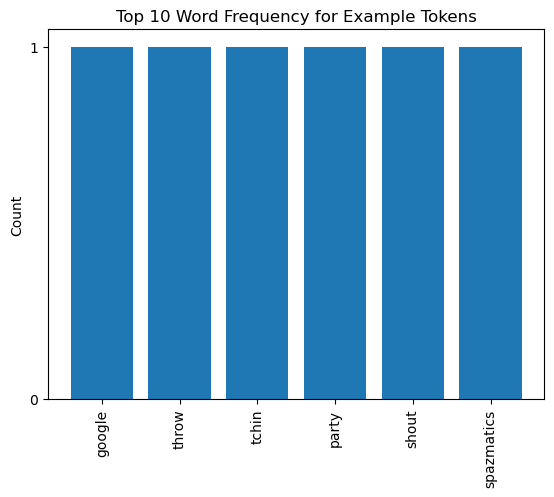

In [69]:
# Importing the relevant package for top number of words
from matplotlib.ticker import MaxNLocator

# Creating a function to visualize the top 10 words

def visualize_top_10(freq_dist, title):
#     extracting data for graph
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
#     Setting up graph and plotting data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    
#     Custominzing plot appearance 
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='x', rotation=90)
    
visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens")

* **FreqDist on the Full DataSet**

In order to calculate the count of words, they need to be stored into a list. To do so, we will `explode` the dataset.  

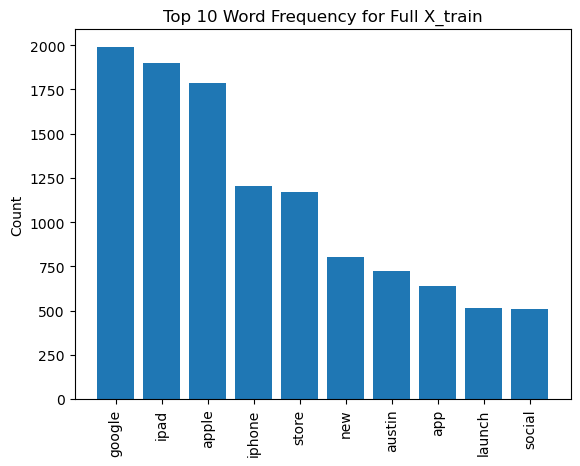

In [70]:
# Creating a frequency distribution for X_train
train_freq_dist = FreqDist(X_train['tweet'].explode())

# Plotting the top 10 tokens
visualize_top_10(train_freq_dist, 'Top 10 Word Frequency for Full X_train')


In [71]:
train_freq_dist.most_common(20)

[('google', 1990),
 ('ipad', 1897),
 ('apple', 1784),
 ('iphone', 1203),
 ('store', 1168),
 ('new', 804),
 ('austin', 721),
 ('app', 641),
 ('launch', 515),
 ('social', 509),
 ('circle', 508),
 ('pop', 459),
 ('android', 442),
 ('today', 433),
 ('ipad2', 361),
 ('network', 356),
 ('get', 343),
 ('via', 331),
 ('line', 325),
 ('party', 299)]

We can also subdivide this by category to see if it makes a difference:

In [72]:
# Adding in labels for filtering
X_train['label'] = [y_train[val] for val in X_train.index]

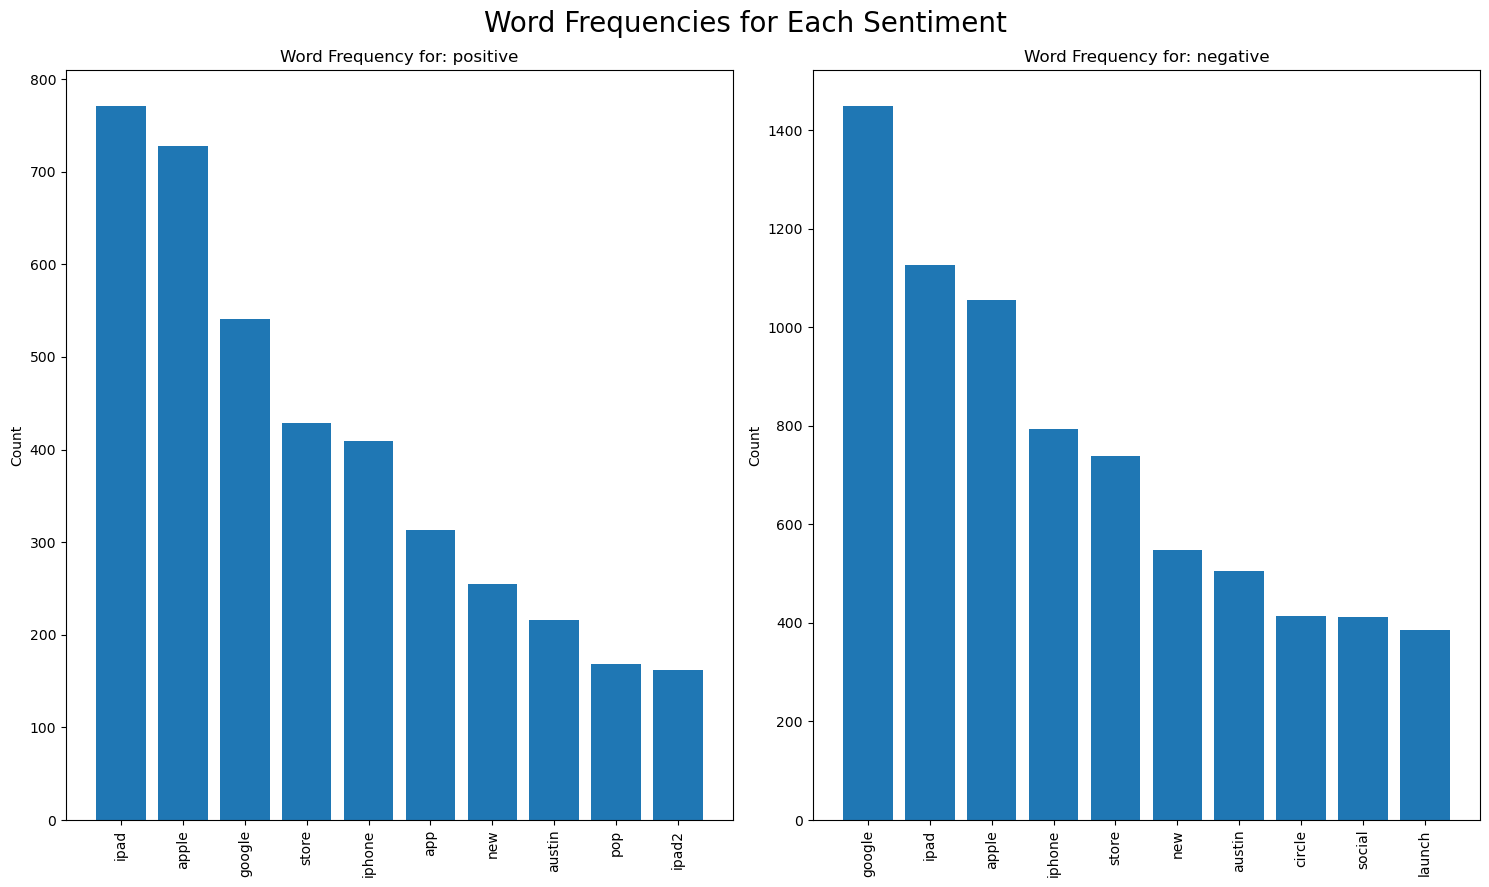

In [73]:
# Defining funcrion to plot 2 visualizations

# Creating two columns 
def two_subplits():
    fig = plt.figure(figsize=(15, 9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 2)
    
    ax1 = fig.add_subplot(gs[0, 0]) #row 0, col 0 
    ax2 = fig.add_subplot(gs[0, 1]) #row 0, col 1 
    return fig, [ax1, ax2]

# Plotting the graph
def plot_distribution_by_sentiment(X_version, column, axes, title = "Word Frequency for:"):
    for index, category in enumerate(X_version['label'].unique()): 
#         Calculating frequency distribution for this subset
        all_words = X_version[X_version['label'] == category][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]
        
        
#         Setting up a plot
        ax = axes[index]
        ax.bar(tokens, counts)
        
#         Customizing plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='x', rotation=90)
        
        
fig, axes = two_subplits()
plot_distribution_by_sentiment(X_train, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

In [74]:
# Frequency distribution
# Defining subset prior. Here: positive, negative, no company tweets

negative_tweets = X_train[X_train['label'] == 'negative']
positive_tweets = X_train[X_train['label'] == 'positive']
no_product_or_company = X_train[X_train['product_or_company'] == 'undefined']

def freq_distr(subset, most_common):
    exploded_subset = subset['tweet'].explode()
    subset_freq = FreqDist(exploded_subset)
    return subset_freq.most_common(most_common)



In [75]:
# Getting frequency distribution for top 20 strings of no_product_or_company
freq_distr(no_product_or_company, 20)

[('google', 1392),
 ('ipad', 1034),
 ('apple', 1001),
 ('store', 733),
 ('iphone', 719),
 ('new', 550),
 ('austin', 504),
 ('social', 404),
 ('circle', 402),
 ('launch', 381),
 ('today', 334),
 ('app', 311),
 ('android', 291),
 ('pop', 286),
 ('network', 279),
 ('via', 236),
 ('called', 223),
 ('line', 209),
 ('free', 207),
 ('ipad2', 203)]

### Wordcloud

In [76]:
# Installing wordcloud
# !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org wordcloud

In [77]:
# Importing relevant packages
from matplotlib.colors import LinearSegmentedColormap

# Defining a colormap that interpolates between the two defined colors
custom_colors = ['#3F3533', '#F5F2EE']
# custom_colors = ['#F5F2EE', '#3F3533']
n_bins = 5 

# Creating the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=n_bins)

In [78]:
# Importing relevant packages 
from wordcloud import WordCloud

# Concatenate all tweets into a single string
all_tweets = ' '.join(X_train['tweet'].apply(lambda x: ' '.join(map(str, x))))

def wordcloud_graph(text):
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='#F5F2EE', colormap=custom_cmap).generate(all_tweets)

    # Display the generated word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


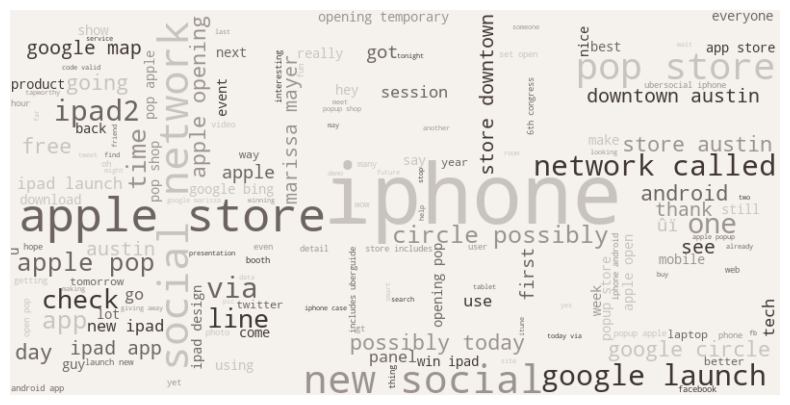

In [79]:
wordcloud_graph(all_tweets)

In [80]:
# If any word need to be reserarched
word_researched = 'quot'
filtered_on_word = X_train[X_train['tweet'].apply(lambda tweet_list: any(word_researched in s for s in tweet_list))]
# filtered_on_word

Whether it comes from the frequency distribution or word cloud, the product and companies are the words that come up the most. 64% of the data does not contain any company or product. We will try filtering on this one to understand if the top words are different.  

In [81]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts(normalize=True)

undefined                          0.638148
iPad                               0.104190
Apple                              0.072657
iPad or iPhone App                 0.051709
Google                             0.047189
iPhone                             0.032635
Other Google product or service    0.032304
Android App                        0.008820
Android                            0.008490
Other Apple product or service     0.003859
Name: product_or_company, dtype: float64

* **No company**

In [82]:
# Create dataframe for undefined product or company
no_company = X_train[X_train['product_or_company'] == 'undefined']

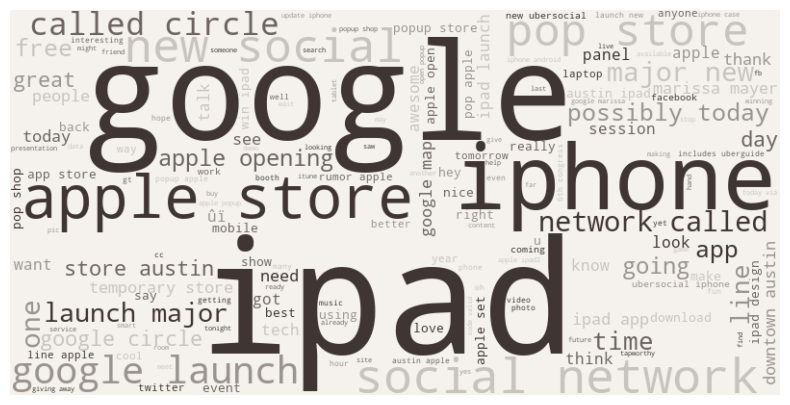

In [83]:
# Concatenate all tweets into a single string
no_company_tweets = ' '.join(no_company['tweet'].apply(lambda x: ' '.join(map(str, x))))

# custom_colors = ['#3F3533', '#F5F2EE']

# def wordcloud_graph(text):
#     # Generate a word cloud
#     wordcloud = WordCloud(width=800, height=400, background_color='#F5F2EE', colormap=custom_cmap).generate(text)

#     # Display the generated word cloud using matplotlib
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.show()
wordcloud_graph(no_company_tweets)

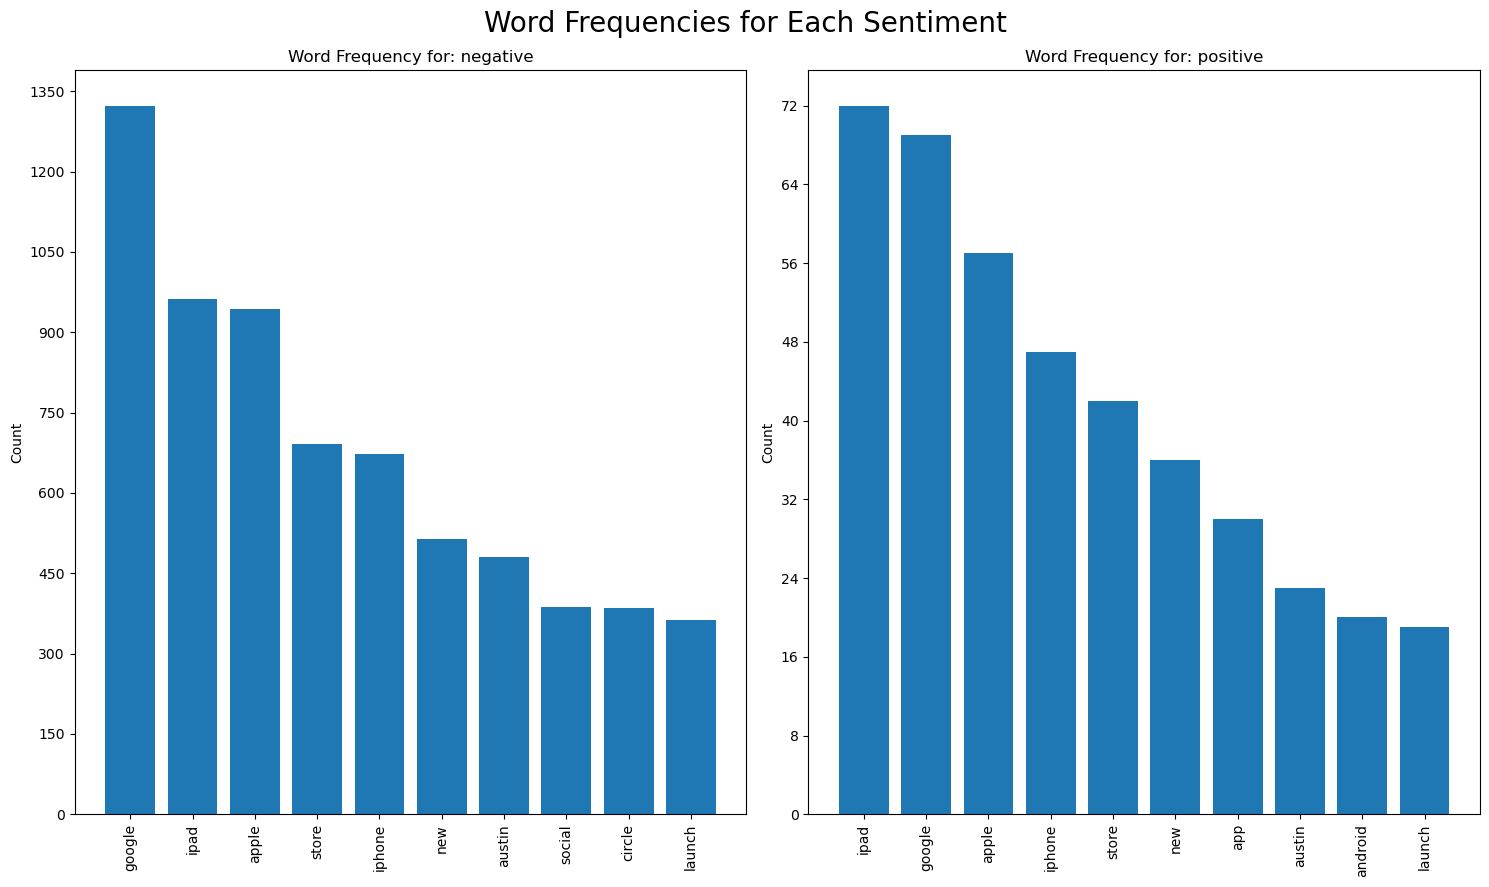

In [84]:
fig, axes = two_subplits()
plot_distribution_by_sentiment(no_company, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

* **Company only**

In [85]:
# Create dataframe for only product or company
company_only = X_train[X_train['product_or_company'] != 'undefined']

In [86]:
company_only

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive
6986,"[yes, updated, iphone, app, song, info, 24, stream, others, also, live, video, streaming]",iPad or iPhone App,RT @mention YES! updated iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link},yes updated iphone app song info 24 stream others also live video streaming,positive
9029,"[top, story, apple, school, marketing, expert, thousand, town, demonstrate, social, mar]",Apple,"[TOP STORY] At #SXSW, Apple schools the marketing experts: Thousands in town to demonstrate their social mar... {link} #sxswi",top story apple school marketing expert thousand town demonstrate social mar,positive
...,...,...,...,...,...
4155,"[si, julie, life, death, rockaroke, struggle, win, ipad, fandango, party, hole, bad, religion, far]",iPad,My sis Julie and I are in a life and death Rockaroke struggle to win her an iPad at the #Fandango #SXSW party. Hole and Bad Religion so far,si julie life death rockaroke struggle win ipad fandango party hole bad religion far,positive
1612,"[nc, buzzing, ipad2, geekdom, austin, elevate, smart, apple]",Apple,"@mention @mention NC is buzzing #iPad2 but geekdom in Austin #SXSW will elevate, smart # Apple.",nc buzzing ipad2 geekdom austin elevate smart apple,positive
2812,"[heck, would, anyone, want, mozilla, switch, crapkit, webkit, gecko, good, stupid, apple, google, bandwaggoners]",Apple,Why the heck would anyone want Mozilla to switch to CrapKit (WebKit) when Gecko is good? Stupid Apple/Google bandwaggoners. #sxsw,heck would anyone want mozilla switch crapkit webkit gecko good stupid apple google bandwaggoners,negative
8571,"[tattoo, ipad, chalked, pavement, mean, applefanatic]",iPad,&quot;Tattoo for an iPad&quot; chalked on the pavement. What can it mean? #sxsw #applefanatic,tattoo ipad chalked pavement mean applefanatic,positive


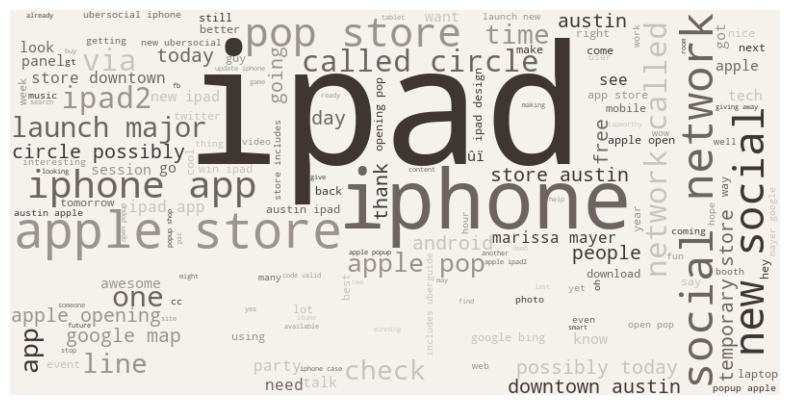

In [87]:
# Concatenate all tweets into a single string
company_tweets = ' '.join(no_company['tweet'].apply(lambda x: ' '.join(map(str, x))))

wordcloud_graph(company_tweets)

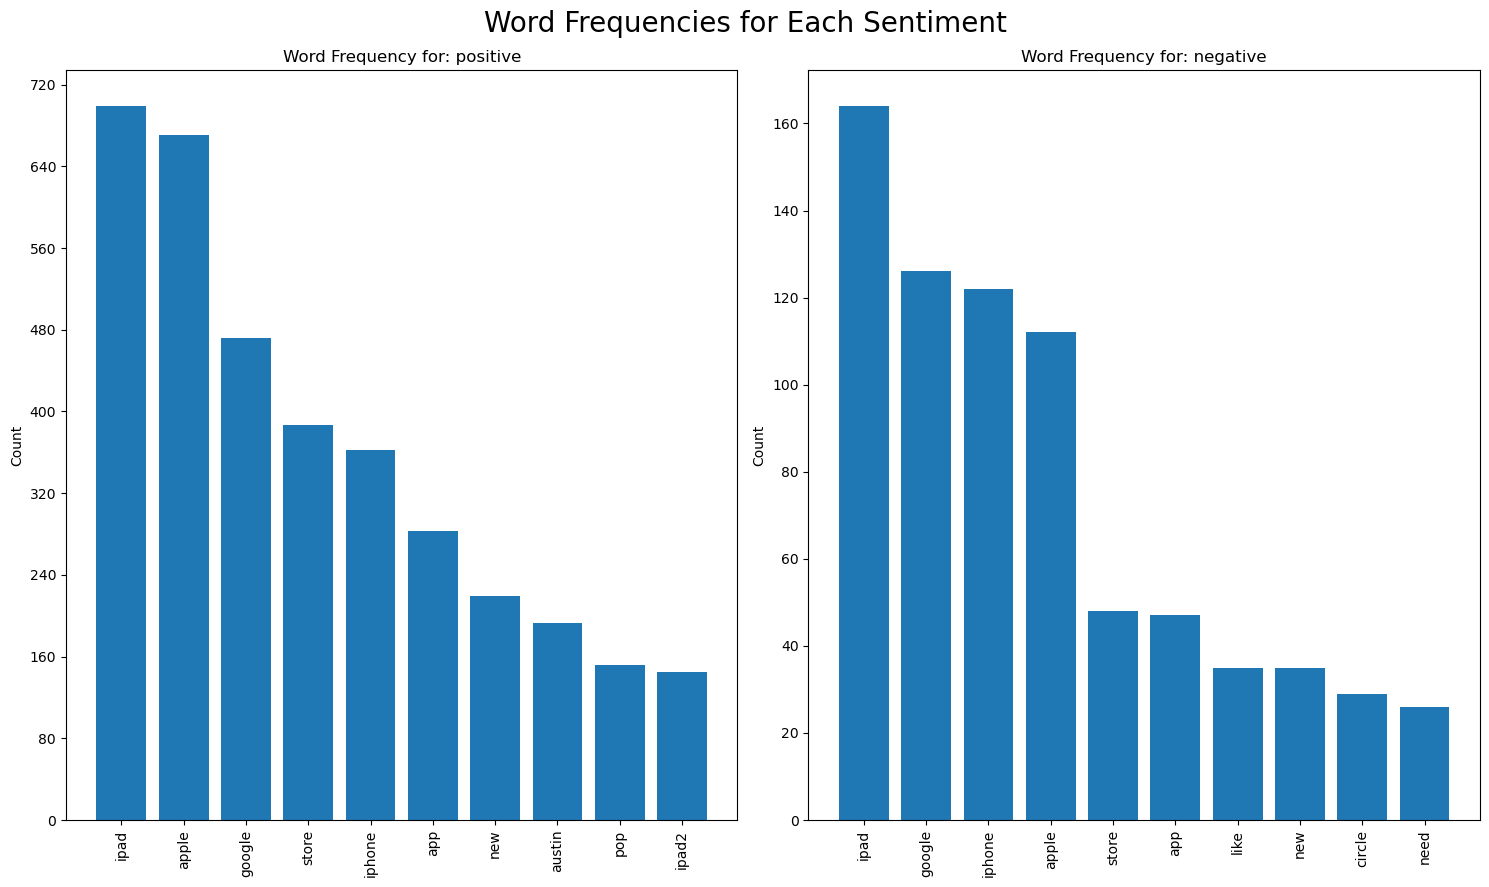

In [88]:
fig, axes = two_subplits()
plot_distribution_by_sentiment(company_only, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

* **No company words**
<br>Because it does not matter much what product or company is mentioned, all these words will be removed.

In [89]:
# Defining list of product or company name to remove
list_of_company_products = ['google', 'android', 'apple', 'ipad', 'iphone', 'ipad2']
# Making a copy of the dataframe to first evaluate
no_product_company = X_train.copy()

In [90]:
no_product_company.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
945,"[20, google, search, local, information, marissa, mayer, million, place, claimed, owner, logged, google]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google,negative
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy,negative
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive


In [91]:
# Removing any word corresponding to product or company
no_product_company['tweet'] = no_product_company['tweet'].apply(
    lambda tweet_list: [word for word in tweet_list if word.lower() not in list_of_company_products]
)

In [92]:
# Verifying if words were removed at first glance
no_product_company.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
945,"[20, search, local, information, marissa, mayer, million, place, claimed, owner, logged]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google,negative
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy,negative
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive


In [93]:
# Actively searching for a word
word_researched = 'ipad'
filtered_on_word = no_product_company[no_product_company['tweet'].apply(lambda tweet_list: any(word_researched in s for s in tweet_list))]

In [94]:
# Calling new dataframe filtered on word
filtered_on_word.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
279,"[technews, opening, pop, store, austin, geekfest, tech_news, brian_lam, ipad_2, tech]",undefined,#technews Apple Opening Pop-Up Store in Austin for SXSW Geekfest [Apple] {link} #Tech_News #Apple #Brian_Lam #iPad_2 #SXSW #tech,technews apple opening pop store austin geekfest apple tech_news apple brian_lam ipad_2 tech,negative
8363,"[hate, fleet, nerd, armed, ipads, navigating, crowd, far, cool, ever, seen]",iPad,"Not to hate on the iPad, but fleets of nerds armed with iPads navigating through crowds is as far from cool as I've EVER seen #sxsw",hate ipad fleet nerd armed ipads navigating crowd far cool ever seen,negative
5541,"[bad, news, update, pop, store, ipads, sure, tomorrow]",undefined,RT @mention Bad news update: the pop-up Apple Store is out of iPads! Not sure if they will have more by tomorrow. #SXSW,bad news update pop apple store ipads sure tomorrow,negative
6696,"[surprise, opened, pop, store, austin, nerd, town, get, new, ipads, cnet]",undefined,RT @mention Surprise! Apple opened a pop-up store in Austin so that the nerds in town for #SXSW can get new iPads. {link} #cnet,surprise apple opened pop store austin nerd town get new ipads cnet,negative
4103,"[picked, great, venue, launch, new, ipads]",Apple,#SXSW Apple picked a great venue to launch the new Ipads.,apple picked great venue launch new ipads,positive


In [95]:
# Concatenate all tweets into a single string
no_prod_comp_list = ' '.join(no_product_company['tweet'].apply(lambda x: ' '.join(map(str, x))))

# wordcloud_graph(no_prod_comp_list)

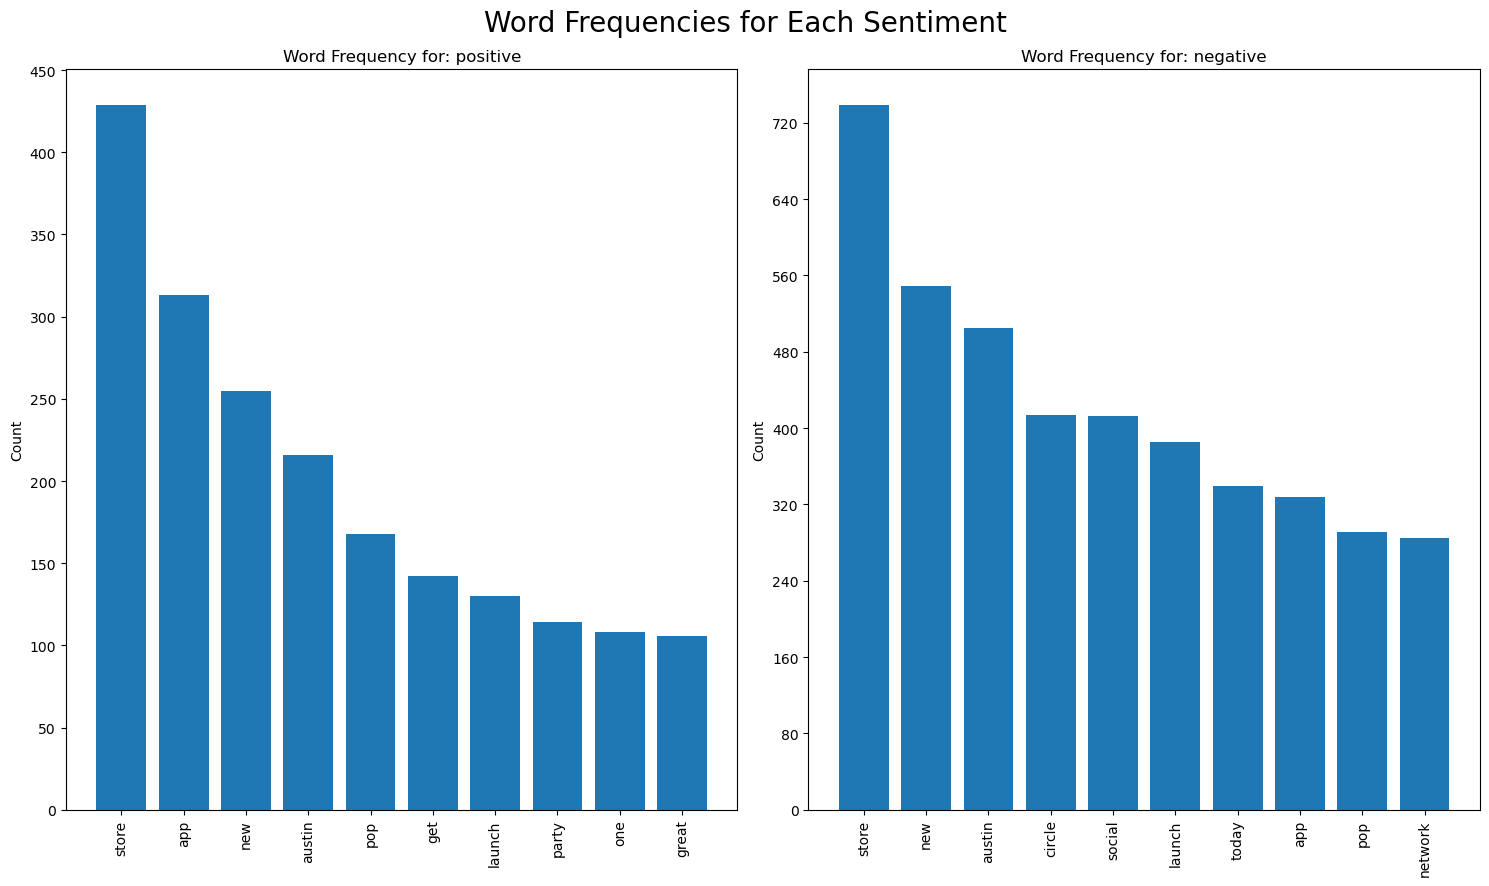

In [96]:
fig, axes = two_subplits()
plot_distribution_by_sentiment(no_product_company, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

In [97]:
# Getting frequency for no_prod_company_tweets
# no_product_company 
positive_tweets_no_comp = no_product_company[no_product_company['label'] == 'positive']
negative_tweets_no_comp = no_product_company[no_product_company['label'] == 'negative']

In [98]:
freq_distr(no_product_company, 20)

[('store', 1168),
 ('new', 804),
 ('austin', 721),
 ('app', 641),
 ('launch', 515),
 ('social', 509),
 ('circle', 508),
 ('pop', 459),
 ('today', 433),
 ('network', 356),
 ('get', 343),
 ('via', 331),
 ('line', 325),
 ('party', 299),
 ('free', 284),
 ('called', 269),
 ('mobile', 263),
 ('one', 243),
 ('time', 227),
 ('major', 223)]

In [99]:
freq_distr(positive_tweets_no_comp, 20)

[('store', 429),
 ('app', 313),
 ('new', 255),
 ('austin', 216),
 ('pop', 168),
 ('get', 142),
 ('launch', 130),
 ('party', 114),
 ('one', 108),
 ('great', 106),
 ('line', 103),
 ('time', 101),
 ('social', 96),
 ('via', 95),
 ('circle', 94),
 ('today', 94),
 ('win', 93),
 ('map', 90),
 ('day', 90),
 ('cool', 89)]

In [100]:
freq_distr(negative_tweets_no_comp, 20)

[('store', 739),
 ('new', 549),
 ('austin', 505),
 ('circle', 414),
 ('social', 413),
 ('launch', 385),
 ('today', 339),
 ('app', 328),
 ('pop', 291),
 ('network', 285),
 ('via', 236),
 ('called', 222),
 ('line', 222),
 ('get', 201),
 ('free', 195),
 ('mobile', 187),
 ('party', 185),
 ('major', 180),
 ('possibly', 146),
 ('temporary', 139)]

Having filtered on no company tweets give us a better idea: positive tweets talk about...
<br>negative tweets talk about ... 

Let's review bigrams to get a better understanding. 

### Bigrams

#### Bigrams

* **All tweets**

In [101]:
# Importing relevant package
from nltk.collocations import *

# Storing nltk.collocations.BigramAssocMeasures into variable
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [102]:
# Defining a function to review bigrams
def bigram_review(text, top_n):
    # Creating a finder and passing it the words of tweets summarized as 1 list  
    text_finder = BigramCollocationFinder.from_words(text.sum())
    text_scored = text_finder.score_ngrams(bigram_measures.raw_freq)
    return text_scored[: top_n]


In [103]:
bigram_review(no_product_company['tweet'], 20)

[(('pop', 'store'), 0.006248214795772636),
 (('social', 'network'), 0.006105398457583547),
 (('new', 'social'), 0.005551985147100829),
 (('called', 'circle'), 0.004480862610682662),
 (('network', 'called'), 0.004302342187946301),
 (('major', 'new'), 0.0038381890888317624),
 (('launch', 'major'), 0.0036953727506426736),
 (('temporary', 'store'), 0.0033204798628963155),
 (('circle', 'possibly'), 0.003124107397886318),
 (('possibly', 'today'), 0.003088403313339046),
 (('store', 'austin'), 0.002767066552413596),
 (('downtown', 'austin'), 0.0025528420451299627),
 (('marissa', 'mayer'), 0.002356469580119966),
 (('store', 'downtown'), 0.0023029134532990573),
 (('popup', 'store'), 0.002070836903741788),
 (('opening', 'temporary'), 0.001570979720079977),
 (('austin', 'launch'), 0.0014817195087117967),
 (('app', 'store'), 0.001356755212796344),
 (('pop', 'shop'), 0.0011246786632390746),
 (('opening', 'pop'), 0.0010532704941445302)]

We saw earlier that the tweets containing company names or products indicated too many of of these strings, and were not relevant for us. We will straight away separate positive and negative tweets from the dataset that contains no product or company information. 

In [104]:
# They were declared before
# positive_tweets_no_comp = no_product_company[no_product_company['label'] == 'positive']
# negative_tweets_no_comp = no_product_company[no_product_company['label'] == 'negative']

* **Positive Tweets**

In [105]:
bigram_review(positive_tweets_no_comp['tweet'], 20)

[(('pop', 'store'), 0.0068745263613727405),
 (('social', 'network'), 0.0035725885027606367),
 (('temporary', 'store'), 0.00319367760095269),
 (('new', 'social'), 0.003139547472122984),
 (('downtown', 'austin'), 0.002923026956804157),
 (('store', 'downtown'), 0.0027606365703150373),
 (('marissa', 'mayer'), 0.0024899859261665043),
 (('called', 'circle'), 0.0024358557973367975),
 (('network', 'called'), 0.002381725668507091),
 (('popup', 'store'), 0.002381725668507091),
 (('launch', 'major'), 0.0021652051531882645),
 (('major', 'new'), 0.0021652051531882645),
 (('store', 'austin'), 0.0021652051531882645),
 (('opening', 'temporary'), 0.0017321641225506116),
 (('circle', 'possibly'), 0.001678033993720905),
 (('possibly', 'today'), 0.001678033993720905),
 (('even', 'begin'), 0.001569773736061492),
 (('austin', 'launch'), 0.0014615134784020786),
 (('come', 'cool'), 0.0014615134784020786),
 (('go', 'conference'), 0.001407383349572372)]

There is enthusiasm with the new pop up store created. And about the new social network created circle. 
High enthusiasm anout the new launch and the Marissa Mayer. 

* **Negative Tweets**

In [106]:
bigram_review(negative_tweets_no_comp['tweet'], 20)

[(('social', 'network'), 0.007351766022055298),
 (('new', 'social'), 0.00673911885355069),
 (('pop', 'store'), 0.005940013851153375),
 (('called', 'circle'), 0.0054871876831282295),
 (('network', 'called'), 0.005247456182409035),
 (('major', 'new'), 0.004661445847317671),
 (('launch', 'major'), 0.0044483511800117205),
 (('circle', 'possibly'), 0.003835704011507112),
 (('possibly', 'today'), 0.0037824303446806246),
 (('temporary', 'store'), 0.003382877843481967),
 (('store', 'austin'), 0.003063235842523041),
 (('downtown', 'austin'), 0.0023706781737787013),
 (('marissa', 'mayer'), 0.00229076767353897),
 (('store', 'downtown'), 0.002077673006233019),
 (('popup', 'store'), 0.001917852005753556),
 (('austin', 'launch'), 0.0014916626711416548),
 (('opening', 'temporary'), 0.0014916626711416548),
 (('app', 'store'), 0.0013318416706621916),
 (('opening', 'pop'), 0.0010921101699429973),
 (('launch', 'new'), 0.0010654733365297534)]

#### Mutual Information Scores

We will calculate mutual information scores and we will create a frequency filter, so that we only examine bigrams that occur more than a set number of times: here, 5. 

In [107]:
def mutual_info_score(text, n_filter):
    text_pmi_finder = BigramCollocationFinder.from_words(text.sum())
    text_pmi_finder.apply_freq_filter(n_filter)
    text_pmi_scored = text_pmi_finder.score_ngrams(bigram_measures.pmi)
    return text_pmi_scored

In [108]:
mutual_info_score(no_product_company['tweet'], 3)[:10]

[(('accordion', 'toodamnlucky'), 14.188588845707347),
 (('conceptual', 'graphing'), 14.188588845707347),
 (('demonstrates', 'pause'), 14.188588845707347),
 (('flaming', 'skull'), 14.188588845707347),
 (('horde', 'purchaser'), 14.188588845707347),
 (('informal', 'unscientific'), 14.188588845707347),
 (('knitted', 'staircase'), 14.188588845707347),
 (('marc', 'ecko'), 14.188588845707347),
 (('matthew', 'davis'), 14.188588845707347),
 (('parakeet', 'employed'), 14.188588845707347)]

In [109]:
mutual_info_score(positive_tweets_no_comp['tweet'], 5)[:10]

[(('league', 'extraordinary'), 11.851280557878614),
 (('lustre', 'pearl'), 11.851280557878614),
 (('security', 'guard'), 11.588246152044817),
 (('south', 'southwest'), 11.36585373070837),
 (('speech', 'therapy'), 11.36585373070837),
 (('150', 'million'), 11.173208652765974),
 (('maggie', 'mae'), 11.173208652765974),
 (('belinsky', '911tweets'), 10.980563574823577),
 (('mark', 'belinsky'), 10.980563574823577),
 (('awesomely', 'rad'), 10.85128055787861)]

In [110]:
mutual_info_score(negative_tweets_no_comp['tweet'], 5)[:10]

[(('acoustic', 'solo'), 12.611255388699337),
 (('charles', 'chen'), 12.611255388699337),
 (('entered', 'automatically'), 12.611255388699337),
 (('jc', 'penney'), 12.611255388699337),
 (('khoi', 'vinh'), 12.611255388699337),
 (('rww', 'f6bcet'), 12.611255388699337),
 (('98', 'accuracy'), 12.38886296736289),
 (('galaxy', 'ii'), 12.38886296736289),
 (('lustre', 'pearl'), 12.38886296736289),
 (('cameron', 'sinclair'), 12.196217889420495)]

## 5. Modeling

*what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?*
* For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice

We want to predict positive sentiments. A false positive would have more impact, because we would base our strategy based on a tweet we thought would positively impact whereas it was actually negative. 
<br>Consequently, precision will be chosen in addition to accuracy. 

In [111]:
# Recall the natural split
y_train.value_counts(normalize=True)

negative    0.672596
positive    0.327404
Name: sentiment, dtype: float64

In [112]:
# If we were to guess that a tweet was positive, we would only get 33% accuracy. 

### 5. a) Baseline Model with TfidfVectorizer and MultinomialNB

We will start modeling by building an initial model which only has access to the information in the plots above. So, using the default token pattern to split the full text into tokens, and using a limited vocabulary. 

To give the model a little bit more information with those same features, `TfidVectorizer` will be used to count the term frequency (`tf`) within a single document. This package also includes the inverse document frequency (`idf`): how rare the term is. 

The first step is to import the vectorizer, instantiate a vectorizer object and fit it on `X_train['tweet']`.

In [113]:
# X_train['tweet'] 

In [114]:
# Importing the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiating a vectorizer with max_features=10 
tfidf = TfidfVectorizer(max_features=10)

# Fitting the vectorizer on X_train['tweet'] and transforming it
# X_train_vectorized = tfidf.fit_transform(X_train['tweet_original'])
X_train_vectorized = tfidf.fit_transform(X_train['tweet_original'])

# Inspecting the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out()).head()

,at,for,google,ipad,link,mention,rt,sxsw,the,to
0,0.000000,0.529305,0.515196,0.0,0.00000,0.000000,0.00000,0.222457,0.433409,0.465918
1,0.000000,0.448731,0.873540,0.0,0.00000,0.000000,0.00000,0.188594,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.87205,0.000000,0.00000,0.489417,0.000000,0.000000
3,0.525116,0.000000,0.000000,0.0,0.00000,0.390906,0.53867,0.242180,0.471835,0.000000
4,0.000000,0.928793,0.000000,0.0,0.00000,0.315039,0.00000,0.195177,0.000000,0.000000


Now that we have preprocessed data, we will fit and evaluate Naive Bayes classifier using `cross_val_score`

In [115]:
# Importing the relevant class function
from sklearn.naive_bayes import MultinomialNB

# Instantiating a MultinomialNB classifier
baseline_model = MultinomialNB()

# Fitting the classifier on X_train_vectorized and y_train
baseline_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [116]:
# Defining a function to calculate evaluation metrics
# Importing the relevant packages
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

# Defining a function eval_scores to calculate and print score metrics for each model

def eval_scores(model_name, model, X, y):
    y_pred = model.predict(X)  # Predict the labels
    y_pred_proba = model.predict_proba(X)  # Predict the probabilities
    
    accuracy_value = accuracy_score(y, y_pred)
    precision_value = precision_score(y, y_pred, pos_label='positive', zero_division=0)
    f1_value = f1_score(y, y_pred, pos_label='positive', zero_division=0)
    cv_score = cross_val_score(model, X, y)
    
    
    print("Evaluation scores for {} ".format(model_name))
    
    print("Accuracy Score: {}".format(accuracy_value))
    print("Precision Score: {}".format(precision_value))
    print("F1 Score: {}".format(f1_value))
    print("Cross Validation Score: {}".format(cv_score.mean()))
    
    
    return accuracy_value, precision_value, f1_value, cv_score
    

In [117]:
# Naming the model and calling the function to evaluate it
bl_model_name = 'Baseline Model with TfidfVectorizer and MultinomialNB'

# Calling the function and recording into the defined values
accuracy_value, precision_value, f1_value, cv_score = eval_scores(bl_model_name, baseline_model, X_train_vectorized, y_train)

Evaluation scores for Baseline Model with TfidfVectorizer and MultinomialNB 
Accuracy Score: 0.672596295207292
Precision Score: 0.0
F1 Score: 0.0
Cross Validation Score: 0.6725963824177724


In [118]:
# Confusion matrix

In [119]:
# Defining a function to print a classification report and initial confusion matrix

import warnings
from sklearn.metrics import confusion_matrix, classification_report

def class_calculation(model, X, y):
    # Test set predictions
    y_pred = model.predict(X)

    # Confusion matrix
    cnf_matrix = confusion_matrix(y, y_pred)
    print(cnf_matrix)

    # Manually handle warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        class_report = classification_report(y, y_pred, zero_division=0)  # Adding zero_division parameter
    print(class_report)
    return cnf_matrix, class_report

In [120]:
# Calling the function
cnf_matrix_b, class_report = class_calculation(baseline_model, X_train_vectorized, y_train)

[[4575    0]
 [2227    0]]
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80      4575
    positive       0.00      0.00      0.00      2227

    accuracy                           0.67      6802
   macro avg       0.34      0.50      0.40      6802
weighted avg       0.45      0.67      0.54      6802



In [121]:
# Importing relevant packages
from matplotlib.colors import LinearSegmentedColormap

# Defining a colormap that interpolates between the two defined colors
custom_colors_cnf = ['#3F3533', '#F5F2EE']

n_bins = 20 

# Creating the custom colormap
custom_cmap_cnf = LinearSegmentedColormap.from_list("custom_cmap", custom_colors_cnf, N=n_bins)

In [122]:
# Displaying visually the confusion matrix 

# Importing the relevant package 
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix_display(model, cnf_matrix):
    # Normalize the confusion matrix
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_normalized, display_labels=model.classes_)

    disp.plot(cmap=custom_cmap_cnf)

    plt.title("Model Performance: Confusion Matrix", fontsize=16)

    # Saving the plot as a PNG with a transparent background
#     plt.savefig('images/confusion_matrix.png', transparent=True)

    plt.show()

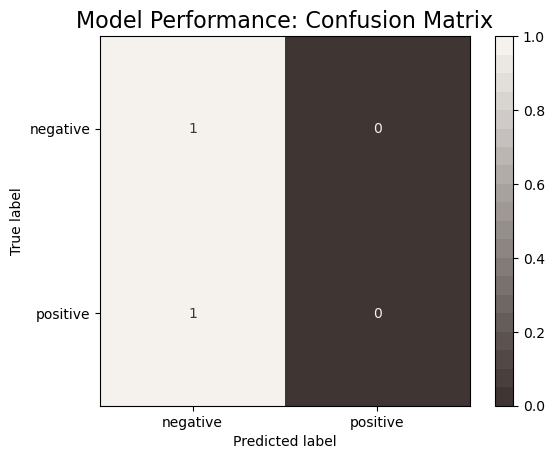

In [123]:
# Calling the function to display the confusion matrix
confusion_matrix_display(baseline_model, cnf_matrix_b)

The precision score returns 0 most likely because it is under represented : <br>
**Verifying the class balance**

In [124]:
# Verifying the class balance
y_train.value_counts(normalize=True)

negative    0.672596
positive    0.327404
Name: sentiment, dtype: float64

How well did the final model perform?

If we guessed the contribution of sentiment every time, we would expect about 33% accuracy. 
Our model baseline is not getting more than just getting every time.  

-----------------------ADD THE OTHER EVALUATION METRICS-----------------------

### <u>2nd iteration</u>: Addressing class imbalance: undersampling negative tweets

In [125]:
# Import relevant packages
from imblearn.under_sampling import RandomUnderSampler
# from sklearn.metrics import classification_report

In [126]:
# Instantiating the undersampler
undersampler = RandomUnderSampler(random_state=42)

# Applying undersampling only on training data
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [127]:
# Inspecting the new class balance
y_resampled.value_counts(normalize=True)

negative    0.5
positive    0.5
Name: sentiment, dtype: float64

In [128]:
# Fitting the vectorizer on X_resampled['tweet'] and transforming it
X_resampled_vectorized = tfidf.fit_transform(X_resampled["tweet_original"])

# Inspecting the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out()).head()

,at,for,google,ipad,link,mention,rt,sxsw,the,to
0,0.000000,0.529305,0.515196,0.0,0.00000,0.000000,0.00000,0.222457,0.433409,0.465918
1,0.000000,0.448731,0.873540,0.0,0.00000,0.000000,0.00000,0.188594,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.87205,0.000000,0.00000,0.489417,0.000000,0.000000
3,0.525116,0.000000,0.000000,0.0,0.00000,0.390906,0.53867,0.242180,0.471835,0.000000
4,0.000000,0.928793,0.000000,0.0,0.00000,0.315039,0.00000,0.195177,0.000000,0.000000


Now that we have preprocessed data, we will fit and evaluate the baseline model on the newly resampled data.

In [129]:
# Fitting the classifier on X_resampled_vectorized and y_resampled
baseline_model.fit(X_resampled_vectorized, y_resampled)

MultinomialNB()

In [130]:
# Naming the model and calling the function to evaluate it
blrs_model_name = 'Resampled Baseline Model with TfidfVectorizer and MultinomialNB'


# Calling the function and recording into the defined values
accuracy_resampled, precision_resampled, f1_resampled, cv_resampled = eval_scores(blrs_model_name, baseline_model, X_resampled_vectorized, y_resampled)

Evaluation scores for Resampled Baseline Model with TfidfVectorizer and MultinomialNB 
Accuracy Score: 0.5633138751683879
Precision Score: 0.5711402623612513
F1 Score: 0.5378949869327632
Cross Validation Score: 0.5599417394923012


The accuracy score drastically decreased, but we now have a precision and f1 scores, indicating the 'positive sentiments' are now correctly represented.  

In [131]:
# Calling the function
cnf_matrix_rs, class_report_rs = class_calculation(baseline_model, X_resampled_vectorized, y_resampled)

[[1377  850]
 [1095 1132]]
              precision    recall  f1-score   support

    negative       0.56      0.62      0.59      2227
    positive       0.57      0.51      0.54      2227

    accuracy                           0.56      4454
   macro avg       0.56      0.56      0.56      4454
weighted avg       0.56      0.56      0.56      4454



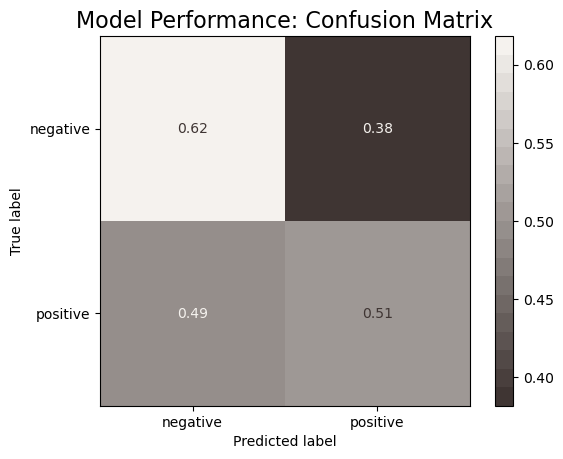

In [132]:
confusion_matrix_display(baseline_model, cnf_matrix_rs)

### <u>3rd iteration</u>: including stopwords

In [133]:
# Instantiating the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

In [134]:
# Fitting the vectorizer on X_resampled['tweet'] and transforming it
X_resampled_vectorized = tfidf.fit_transform(X_resampled["tweet_original"])

# Inspecting the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out()).head()

,amp,app,apple,austin,google,ipad,iphone,new,quot,store
0,0.000000,0.529305,0.515196,0.0,0.00000,0.000000,0.00000,0.222457,0.433409,0.465918
1,0.000000,0.448731,0.873540,0.0,0.00000,0.000000,0.00000,0.188594,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.87205,0.000000,0.00000,0.489417,0.000000,0.000000
3,0.525116,0.000000,0.000000,0.0,0.00000,0.390906,0.53867,0.242180,0.471835,0.000000
4,0.000000,0.928793,0.000000,0.0,0.00000,0.315039,0.00000,0.195177,0.000000,0.000000


Now that we have preprocessed data, we will fit and evaluate the baseline model on the newly resampled data.

In [135]:
# Fitting the classifier on X_resampled_vectorized and y_resampled
baseline_model.fit(X_resampled_vectorized, y_resampled)

MultinomialNB()

In [136]:
# Naming the model and calling the function to evaluate it
stopwords_model_name = 'Resampled Baseline Model with TfidfVectorizer and MultinomialNB'


# Calling the function and recording into the defined values
accuracy_stopwords, precision_stopwords, f1_stopwords, cv_stopwords = eval_scores(stopwords_model_name, baseline_model, X_resampled_vectorized, y_resampled)

Evaluation scores for Resampled Baseline Model with TfidfVectorizer and MultinomialNB 
Accuracy Score: 0.5884598114054782
Precision Score: 0.5968534906588004
F1 Score: 0.5698192912461864
Cross Validation Score: 0.5709464179876165


The accuracy score increased again, but remains low. 

In [137]:
# Calling the function
cnf_matrix_rs, class_report_rs = class_calculation(baseline_model, X_resampled_vectorized, y_resampled)

[[1407  820]
 [1013 1214]]
              precision    recall  f1-score   support

    negative       0.58      0.63      0.61      2227
    positive       0.60      0.55      0.57      2227

    accuracy                           0.59      4454
   macro avg       0.59      0.59      0.59      4454
weighted avg       0.59      0.59      0.59      4454



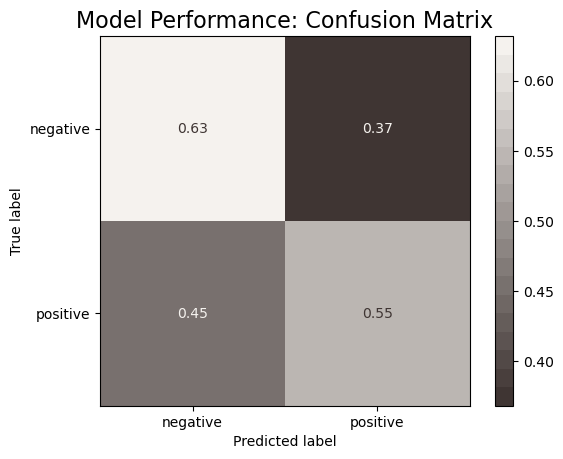

In [138]:
confusion_matrix_display(baseline_model, cnf_matrix_rs)

The accuracy score increased again, but remains low. Let's try to apply the model to the fully preprocessed tweet.

### <u>4th iteration</u>: Applying the full preprocessing to tweets

In [139]:
X_train.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
945,"[20, google, search, local, information, marissa, mayer, million, place, claimed, owner, logged, google]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google,negative
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy,negative
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive


In [140]:
# Instantiating the vectorizer
tfidf = TfidfVectorizer(
    max_features=10
)

In [144]:
# Fitting the vectorizer on X_resampled['tweet'] and transforming it
X_resampled_preprocessed = tfidf.fit_transform(X_resampled['tokenized_tweet'])

# Inspecting the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_resampled_preprocessed, columns=tfidf.get_feature_names_out()).head()

,app,apple,austin,google,ipad,iphone,launch,new,pop,store
0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.000000,0.0,1.00000,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.652942,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.757408
4,0.0,0.364442,0.506875,0.0,0.34829,0.0,0.556989,0.0,0.0,0.422749


Now that we have preprocessed data, we will fit and evaluate the baseline model on the newly resampled data.

In [145]:
# Fitting the classifier on X_resampled_vectorized and y_resampled
baseline_model.fit(X_resampled_preprocessed, y_resampled)

MultinomialNB()

In [146]:
# Naming the model and calling the function to evaluate it
preprocessed_model_name = 'Preprocessed Model with TfidfVectorizer and MultinomialNB'


# Calling the function and recording into the defined values
accuracy_preprocessed, precision_preprocessed, f1_preprocessed, cv_preprocessed = eval_scores(preprocessed_model_name, baseline_model, X_resampled_preprocessed, y_resampled)

Evaluation scores for Preprocessed Model with TfidfVectorizer and MultinomialNB 
Accuracy Score: 0.5916030534351145
Precision Score: 0.5962264150943396
F1 Score: 0.5815504945939728
Cross Validation Score: 0.5671324985182664


The accuracy score drastically decreased, but we now have a precision and f1 scores, indicating the 'positive sentiments' are now correctly represented.  

In [157]:
# Calling the function
cnf_matrix_rs, class_report_rs = class_calculation(baseline_model, X_resampled_preprocessed, y_resampled)

[[1371  856]
 [ 963 1264]]
              precision    recall  f1-score   support

    negative       0.59      0.62      0.60      2227
    positive       0.60      0.57      0.58      2227

    accuracy                           0.59      4454
   macro avg       0.59      0.59      0.59      4454
weighted avg       0.59      0.59      0.59      4454



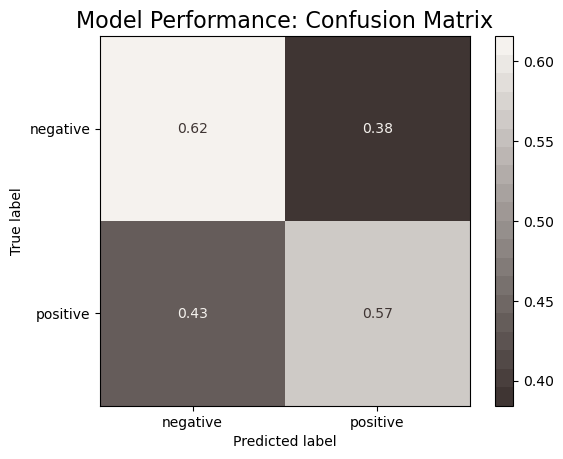

In [158]:
confusion_matrix_display(baseline_model, cnf_matrix_rs)

In [93]:
print("Baseline:         ", baseline_cv.mean())
print("Balanced:         ", balanced_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Manual Stopwords removed:", manual_stopwords_removed_cv.mean())
print("Lemmatized:", lemmatized_cv.mean())

Baseline:          0.3274036175822276
Balanced:          0.4400582605076987
Stopwords removed: 0.4290535820123836
Manual Stopwords removed: 0.4414007742846694
Lemmatized: 0.44747247758483716


### <u>4th iteration</u>: Tuning Tfidf Vectorizer - Hyperparameter tuning

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline with the vectorizer and classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid to search over
parameters = {
    'tfidf__max_features': [10, 50, 100, None],
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.05, 0.1],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__stop_words': [None, 'english'],
}


In [192]:
# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracay')
grid_search.fit(X_resampled['tweet_original'], y_resampled)



ValueError: 'accuracay' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [186]:
# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best parameters to instantiate the final pipeline
best_pipeline = grid_search.best_estimator_

# Transform the full training data using the best vectorizer
X_train_vectorized_final = best_pipeline.named_steps['tfidf'].transform(X_train['tweet_original'])

# Fit the final model on the full training data
best_pipeline.named_steps['classifier'].fit(X_train_vectorized_final, y_train)

Best Parameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': None, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}


MultinomialNB()

In [187]:
# Naming the model and calling the function to evaluate it
tuned_model_name = 'Hyperparameter Tuned Model with TfidfVectorizer and MultinomialNB'


# Calling the function and recording into the defined values
accuracy_tuned, precision_tuned, f1_tuned, cv_tuned = eval_scores(tuned_model_name, \
                                                                  best_pipeline, X_resampled['tweet_original'], y_resampled)


Evaluation scores for Hyperparameter Tuned Model with TfidfVectorizer and MultinomialNB 
Accuracy Score: 0.5590480466995958
Precision Score: 0.8662952646239555
F1 Score: 0.24052590873936583
Cross Validation Score: 0.619886757714473


The accuracy score drastically decreased, but we now have a precision and f1 scores, indicating the 'positive sentiments' are now correctly represented.  

In [188]:
# Calling the function
cnf_matrix_tuned, class_report_tuned = class_calculation(best_pipeline, X_resampled['tweet_original'], y_resampled)

[[2179   48]
 [1916  311]]
              precision    recall  f1-score   support

    negative       0.53      0.98      0.69      2227
    positive       0.87      0.14      0.24      2227

    accuracy                           0.56      4454
   macro avg       0.70      0.56      0.46      4454
weighted avg       0.70      0.56      0.46      4454



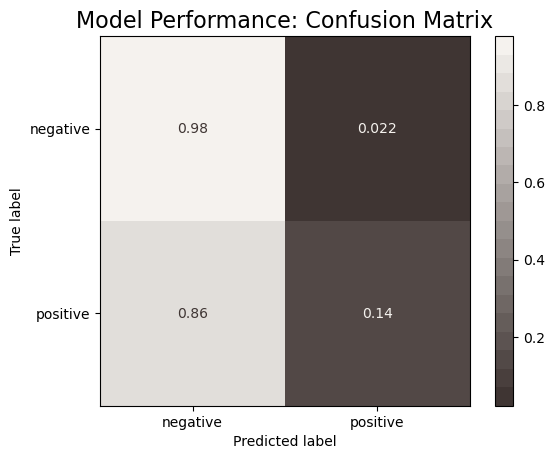

In [189]:
confusion_matrix_display(best_pipeline.named_steps['classifier'], cnf_matrix_tuned)

### <u>5th iteration</u>: RandomForestClassifierTuning Tfidf Vectorizer - Hyperparameter tuning

In [190]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [195]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have best TF-IDF parameters from a previous grid search
best_tfidf_params = {
    'max_features': 100,
    'max_df': 0.95,
    'min_df': 0.01,
    'sublinear_tf': True,
    'ngram_range': (1, 2),
    'stop_words': 'english'
}

# Define the pipeline with the fixed TF-IDF parameters and RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**best_tfidf_params)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt'))
])

# No need for GridSearchCV for TF-IDF, as parameters are fixed

# Fit the pipeline on the resampled data
pipeline.fit(X_resampled['tweet_original'], y_resampled)

# Transform the full training data using the fixed TF-IDF vectorizer
X_train_vectorized_final = pipeline.named_steps['tfidf'].transform(X_train['tweet_original'])

# Fit the RandomForestClassifier on the full training data with manual parameters
pipeline.named_steps['classifier'].fit(X_train_vectorized_final, y_train)


RandomForestClassifier(max_depth=10)

In [196]:
# Naming the model and calling the function to evaluate it
rf_tuned_model_name = 'Hyperparameter Tuned RandomForest Model'


# Calling the function and recording into the defined values
accuracy_rf, precision_rf, f1_rf, cv_tuned = eval_scores(rf_tuned_model_name, \
                                                                  best_pipeline, X_resampled['tweet_original'], y_resampled)


Evaluation scores for Hyperparameter Tuned RandomForest Model 
Accuracy Score: 0.5590480466995958
Precision Score: 0.8662952646239555
F1 Score: 0.24052590873936583
Cross Validation Score: 0.619886757714473


The accuracy score drastically decreased, but we now have a precision and f1 scores, indicating the 'positive sentiments' are now correctly represented.  

In [197]:
# Calling the function
cnf_matrix_rf, class_report_rf = class_calculation(pipeline, X_resampled['tweet_original'], y_resampled)

[[2220    7]
 [1876  351]]
              precision    recall  f1-score   support

    negative       0.54      1.00      0.70      2227
    positive       0.98      0.16      0.27      2227

    accuracy                           0.58      4454
   macro avg       0.76      0.58      0.49      4454
weighted avg       0.76      0.58      0.49      4454



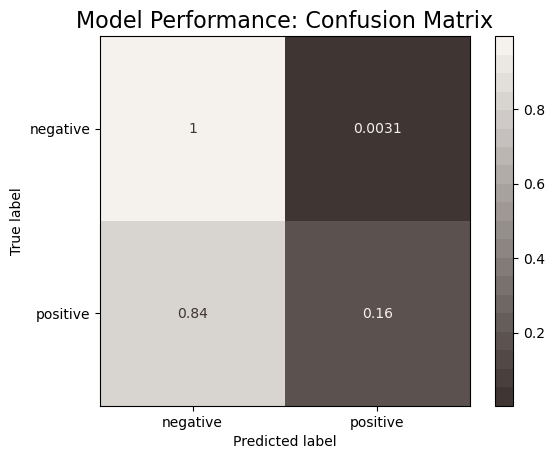

In [199]:
confusion_matrix_display(pipeline.named_steps['classifier'], cnf_matrix_rf)

## 6. Evaluation

*how well did your final model perform?*
* Include one or more relevant metrics
 
* Be sure to briefly describe your validation approach

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 7. Findings & Recommendations

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 8. Limits & Next Steps

Text Text Text Text Text Text 

Text Text Text Text Text Text 